# Homework 2

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Yumeng Zhang (12372205)
* ymzhang@uchicago.edu

This homework relies on:

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate  bonds symbology file `corp_symbology` and
- the market data file `market_prices_eod`.


# Problem 1: Constructing fixed rate bonds

In [1]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt

# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

## a. Prepare common symbology dataframe for fixed rate government and corporate bonds

Load the `govt_symbology` and `corp_symbology` Excel files into one common dataframe, using the `corp_symbology` columns. Filter the dataframe and keep fixed rate bonds only: (cpn_type="FIXED").


In [2]:
def get_common_symbology():

    df_govt_symbology = pd.read_excel('data/govt_symbology.xlsx', sheet_name='Sheet1')
    df_corp_symbology = pd.read_excel('data/corp_symbology.xlsx', sheet_name='Sheet1')

    missing_columns = set(df_corp_symbology.columns) - set(df_govt_symbology.columns)
    for col in missing_columns:
        df_govt_symbology[col] = np.nan

    df_symbology = pd.concat([df_govt_symbology, df_corp_symbology[df_govt_symbology.columns]], axis=0, ignore_index=True)
    df_symbology = df_symbology.reindex(columns = df_corp_symbology.columns)
    df_symbology = df_symbology.loc[df_symbology['cpn_type'] == 'FIXED'].reset_index(drop=True)

    return df_symbology

In [3]:
df_symbology = get_common_symbology()
df_symbology

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,mty_typ,rank,country,currency
0,T,Govt,BBG000DLJF04,US912810EQ77,TSRYS4493810,NaN,T 6 1/4 08/15/23,US TREASURY N/B,US GOVERNMENT,6.250,...,2.0,1,1993-08-16,1994-02-15,1993-08-15,2023-08-15,NaN,NaN,US,USD
1,T,Govt,BBG000DKZWK9,US912810ES34,TSRYS4493811,NaN,T 7 1/2 11/15/24,US TREASURY N/B,US GOVERNMENT,7.500,...,2.0,1,1994-08-15,1994-11-15,1994-05-15,2024-11-15,NaN,NaN,US,USD
2,T,Govt,BBG000DLBVY0,US912810ET17,TSRYS4493812,NaN,T 7 5/8 02/15/25,US TREASURY N/B,US GOVERNMENT,7.625,...,2.0,1,1995-02-15,1995-08-15,1995-02-15,2025-02-15,NaN,NaN,US,USD
3,T,Govt,BBG000DQQNJ8,US912810EV62,TSRYS4493813,NaN,T 6 7/8 08/15/25,US TREASURY N/B,US GOVERNMENT,6.875,...,2.0,1,1995-08-15,1996-02-15,1995-08-15,2025-08-15,NaN,NaN,US,USD
4,T,Govt,BBG000DPXMD0,US912810EW46,TSRYS4493814,NaN,T 6 02/15/26,US TREASURY N/B,US GOVERNMENT,6.000,...,2.0,1,1996-02-15,1996-08-15,1996-02-15,2026-02-15,NaN,NaN,US,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,VZ,Corp,BBG017BR3G75,US92346MJT99,VZ5414106,US91282CGT27,VZ 4.15 05/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.150,...,2.0,2,2022-05-19,2022-11-15,2022-05-19,2029-05-15,CALLABLE,Sr Unsecured,US,USD
547,VZ,Corp,BBG017QYK9Z0,US92346MJZ59,VZ5420578,US912810TL26,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.650,...,2.0,2,2022-06-03,2022-12-15,2022-06-03,2052-06-15,CALLABLE,Sr Unsecured,US,USD
548,VZ,Corp,BBG0191HMXJ3,US92346MKG59,VZ5458130,US912810TL26,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.600,...,2.0,2,2022-08-11,2023-02-15,2022-08-11,2052-08-15,CALLABLE,Sr Unsecured,US,USD
549,VZ,Corp,BBG019LXC9P3,US92346MKQ32,VZ5477070,US91282CGT27,VZ 4 1/2 09/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.500,...,2.0,2,2022-09-22,2023-03-15,2022-09-22,2029-09-15,CALLABLE,Sr Unsecured,US,USD


## b. Add function to construct generic fixed rate cashflow schedules from symbology data

Use one row of the symbology dataframe as input  to the function. Use the helper function to convert a date string to a QuantLib date object.

In [4]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")

In [5]:
def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity'])    # use date helper function and update code !!!
    
    # Create acc_first from details['acc_first']
    acc_first = get_ql_date(details['acc_first'])   # use date helper function and update code !!!
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    # all values in cpn_freq in df_symbology are 2.0 (Yumeng)
    period = ql.Period(2)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule

In [6]:
details_ = df_symbology.iloc[0].to_dict()
schedule_ = create_schedule_from_symbology(details_)

## c. Add function to construct generic fixed rate bond objects from symbology data

Use one row of the symbology dataframe as input to the function. Use create_schedule_from_symbology() internally to create the cashflow schedule.

In [7]:
def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
    # Create day_count from details['dcc']
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    # For US Corporates use ql.Thirty360(ql.Thirty360.USA)

    # day_count = ql.Thirty360(ql.Thirty360.USA)   # update code depending on dcc !!!

    if details['dcc'] == 'ACT/ACT':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    elif details['dcc'] == '30/360':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date'])    # use date helper function and update code !!!
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond

In [8]:
details_ = df_symbology.iloc[0].to_dict()
fixed_rate_bond_ = create_bond_from_symbology(details_)

## d. Add function that returns a dataframe with (future) cash flows details for a bond object

Use the "Investigate Bond Cashflows" section in the Quantlib introductory notebook as a template.

The results dataframe should contain following columns:


| CashFlowDate | CashFlowAmount | CashFlowYearFrac |
|----------|-------|-------------|

Pick one government and one corporate bond from symbology, create the bond objects and display the future cashflows.

In [9]:
def get_bond_cashflows(bond: ql.FixedRateBond, calc_date=ql.Date) -> pd.DataFrame:
    '''Returns all future cashflows as of calc_date, i.e. with payment dates > calc_date.
    '''    
    
    # update code!!!
    # cashflows_df = pd.DataFrame()

    x = [(cf.date(), cf.amount()) for cf in bond.cashflows()]
    cf_date, cf_amount = zip(*x)
    cashflows_df = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowAmount': cf_amount})

    discount_yearfrac = np.zeros((len(cashflows_df,)))

    flat_rate = ql.SimpleQuote(0.05)
    rate_handle = ql.QuoteHandle(flat_rate)
    day_count = ql.Actual360()
    continuous_comp = ql.Continuous

    flat_yield_curve = ql.FlatForward(calc_date, rate_handle, day_count, continuous_comp)

    i = 0
    for cf_date in cashflows_df['CashFlowDate']:
        discount_yearfrac[i] = flat_yield_curve.dayCounter().yearFraction(flat_yield_curve.referenceDate(), cf_date)
        i += 1

    cashflows_df['CashFlowYearFrac'] = discount_yearfrac

    cashflows_df = cashflows_df.loc[cashflows_df['CashFlowDate'] > calc_date].reset_index(drop=True)
    
    return cashflows_df

In [10]:
# government bond

details_govt = df_symbology.iloc[300].to_dict()
print(details_govt['class'])
print(details_govt['ticker'])
print(details_govt['figi'])
print(details_govt['isin'])

bond_govt = create_bond_from_symbology(details_govt)
cf_govt = get_bond_cashflows(bond_govt, calc_date)

cf_govt

Govt
T
BBG01994SXY1
US91282CFJ53


,CashFlowDate,CashFlowAmount,CashFlowYearFrac
0,"August 31st, 2023",1.5625,0.386111
1,"February 29th, 2024",1.5625,0.891667
2,"August 31st, 2024",1.5625,1.402778
3,"February 28th, 2025",1.5625,1.905556
4,"August 31st, 2025",1.5625,2.416667
5,"February 28th, 2026",1.5625,2.919444
6,"August 31st, 2026",1.5625,3.430556
7,"February 28th, 2027",1.5625,3.933333
8,"August 31st, 2027",1.5625,4.444444
9,"February 29th, 2028",1.5625,4.950000


In [11]:
# corporate bond

details_corp = df_symbology.iloc[450].to_dict()
print(details_corp['class'])
print(details_corp['ticker'])
print(details_corp['figi'])
print(details_corp['isin'])

bond_corp = create_bond_from_symbology(details_corp)
cf_corp = get_bond_cashflows(bond_corp, calc_date)

cf_corp

Corp
ORCL
BBG00SXGDGM2
US68389XBW48


,CashFlowDate,CashFlowAmount,CashFlowYearFrac
0,"October 1st, 2023",1.8,0.472222
1,"April 1st, 2024",1.8,0.980556
2,"October 1st, 2024",1.8,1.488889
3,"April 1st, 2025",1.8,1.994444
4,"October 1st, 2025",1.8,2.502778
5,"April 1st, 2026",1.8,3.008333
6,"October 1st, 2026",1.8,3.516667
7,"April 1st, 2027",1.8,4.022222
8,"October 1st, 2027",1.8,4.530556
9,"April 1st, 2028",1.8,5.038889


# Problem 2: US Treasury yield curve calibration (On-The-Runs)

## a. Create the on-the-run US treasury bond objects

Restrict the symbology + market data dataframe to on-the-run US treasury notes only (excluding Treasury Bills) and create the treasury bond objects.

Extend the treasuries symbology dataframe with the following market data columns (code from Homework 1):


| date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

In [12]:
def calculate_ttm(df):

    dc = ql.Actual360()

    # initial time-to-maturity
    df['term'] = df.apply(lambda x: dc.yearFraction(ql.Date(x['start_date'].day, x['start_date'].month, x['start_date'].year),
                            ql.Date(x['maturity'].day, x['maturity'].month, x['maturity'].year)), axis=1)

    # current time-to-maturity
    # today = date.today()
    today = dt.date(2023, 4, 14)
    df['TTM'] = df.apply(lambda x: dc.yearFraction(ql.Date(today.day, today.month, today.year),
                            ql.Date(x['maturity'].day, x['maturity'].month, x['maturity'].year)), axis=1)

    return df

def get_on_the_run_treasury(df_govt_on_the_run):

    mask = ~df_govt_on_the_run['ticker'].str.contains('B Govt|C Govt')
    df_govt_current_run = df_govt_on_the_run[mask].reset_index(drop=True)

    return df_govt_current_run


def get_on_the_run_treasury2(df_govt_symbology, df_govt_current_run, df_market):

    df_treasury_run = pd.merge(df_govt_symbology, df_govt_current_run, how='left', left_on=['isin','figi'], right_on = ['isin','figi']).dropna()
    df_treasury_run = pd.merge(df_treasury_run, df_market, how='left', left_on=['isin','figi'], right_on = ['isin','figi']).dropna()

    df_treasury_run = df_treasury_run.rename(columns={'mid_clean': 'mid','date_x':'date'})
    df_treasury_run = df_treasury_run[['cpn_type','dcc', 'cpn_freq','start_date','days_settle' ,'cpn_first', 'acc_first', 'coupon','maturity','date','bid','ask','mid','bid_yield','ask_yield','mid_yield','term','TTM']]

    return df_treasury_run

In [13]:
df_govt_symbology = pd.read_excel('data/govt_symbology.xlsx', sheet_name='Sheet1')
df_govt_symbology = calculate_ttm(df_govt_symbology)

df_govt_on_the_run = pd.read_excel('data/govt_on_the_run.xlsx', sheet_name='Sheet1')
df_govt_current_run = get_on_the_run_treasury(df_govt_on_the_run)

df_market = pd.read_excel('data/market_prices_eod-1.xlsx', sheet_name='Sheet1')
df_market['mid_yield'] = (df_market['bid_yield'] + df_market['ask_yield'])/2

df_treasury_symbology = get_on_the_run_treasury2(df_govt_symbology, df_govt_current_run, df_market)

In [14]:
df_treasury_symbology

,cpn_type,dcc,cpn_freq,start_date,days_settle,cpn_first,acc_first,coupon,maturity,date,bid,ask,mid,bid_yield,ask_yield,mid_yield,term,TTM
0,FIXED,ACT/ACT,2.0,2023-02-15,1,2023-08-15,2023-02-15,3.625,2053-02-15,2023-04-14,97.9531,98.0313,97.9922,3.739,3.735,3.7370,30.438889,30.277778
1,FIXED,ACT/ACT,2.0,2023-02-28,1,2023-08-15,2023-02-15,3.875,2043-02-15,2023-04-14,100.2969,100.3750,100.3359,3.853,3.847,3.8500,20.255556,20.130556
2,FIXED,ACT/ACT,2.0,2023-02-15,1,2023-08-15,2023-02-15,3.500,2033-02-15,2023-04-14,99.8438,99.8906,99.8672,3.519,3.513,3.5160,10.147222,9.986111
3,FIXED,ACT/ACT,2.0,2023-03-31,1,2023-09-30,2023-03-31,3.625,2030-03-31,2023-04-14,100.3750,100.4375,100.4063,3.563,3.553,3.5580,7.102778,7.063889
4,FIXED,ACT/ACT,2.0,2023-03-31,1,2023-09-30,2023-03-31,3.625,2028-03-31,2023-04-14,100.0703,100.0859,100.0781,3.609,3.606,3.6075,5.075000,5.036111
5,FIXED,ACT/ACT,2.0,2023-03-31,1,2023-09-30,2023-03-31,3.875,2025-03-31,2023-04-14,99.5703,99.5820,99.5762,4.105,4.099,4.1020,2.030556,1.991667
6,FIXED,ACT/ACT,2.0,2023-04-17,1,2023-10-15,2023-04-15,3.750,2026-04-15,2023-04-14,99.7578,99.7734,99.7656,3.836,3.831,3.8335,3.038889,3.047222


## b. Calibrate the on-the-run treasury yield curve (bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from the on-the-run treasury dataframe. Calibrate the bid, ask and mid discount factor curves as of 2023-04-14.

In [15]:
def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    yield_curve.enableExtrapolation()
    return yield_curve

## c. Plot the calibrated US Treasury yield (zero rate) curves

Create a graph/scatter plot of the newly computed mid yields by maturity.

In [16]:
def plot_zero_date(df_treasury_symbology, yield_curve):

    df_calibrated_zero_rate = df_treasury_symbology[['maturity']]

    df_calibrated_zero_rate['zero_rate'] = 0.0

    day_count = ql.ActualActual(ql.ActualActual.ISMA)
    compounding = ql.Compounded

    for i in range(len(df_calibrated_zero_rate)):

        maturity = df_calibrated_zero_rate['maturity'][i]
        maturity = ql.Date(maturity.day, maturity.month, maturity.year)

        zero_rate = yield_curve.zeroRate(maturity, day_count, compounding).rate()

        df_calibrated_zero_rate['zero_rate'][i] = zero_rate

    df_calibrated_zero_rate = df_calibrated_zero_rate.sort_values(by=['maturity']).reset_index(drop=True)

    plt.figure(figsize=(20,8))

    plt.title("Calibrated US Treasury mid yields by maturity")
    plt.xlabel("Maturity Date")
    plt.ylabel("Zero Rate")

    plt.plot(df_calibrated_zero_rate['maturity'], df_calibrated_zero_rate['zero_rate'], '-o')

    plt.grid(True)

    plt.show();

In [17]:
yield_curve = calibrate_yield_curve_from_frame(calc_date, df_treasury_symbology, 'mid')

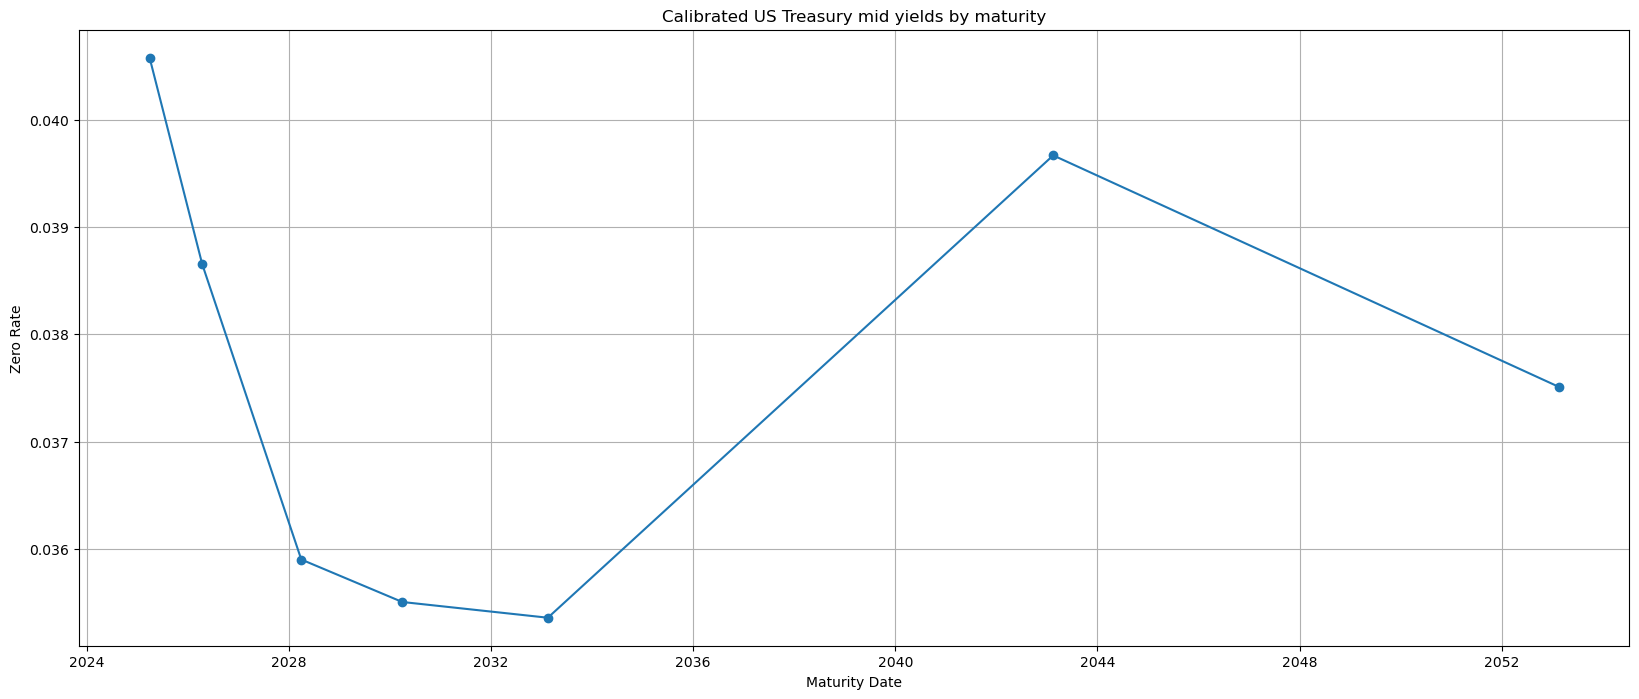

In [18]:
plot_zero_date(df_treasury_symbology, yield_curve)

## d. Plot calibrated discount factors

Plot the discount factor curve up to the 30 years point, using a 6 months discretization grid.

In [19]:
def plot_discount_factor(yield_curve):

    start_date = dt.datetime(2023, 6, 30)
    end_date = dt.datetime(2053, 12, 31)
    date_list = pd.date_range(start=start_date, end=end_date, freq='6M').tolist()
    discount_factor_list = []

    for date in date_list:

        ql_date = ql.Date(date.day, date.month, date.year)
        discount_factor_list.append(yield_curve.discount(ql_date))

    df_discount_factor = {'date': date_list, 'discount_factor': discount_factor_list}

    df_discount_factor = pd.DataFrame(df_discount_factor)

    plt.figure(figsize=(20,8))

    plt.title("Calibrated Discount Factors")
    plt.xlabel("Date")
    plt.ylabel("Discount Factors")

    plt.plot(df_discount_factor['date'], df_discount_factor['discount_factor'], '-o')

    plt.grid(True)

    plt.show();

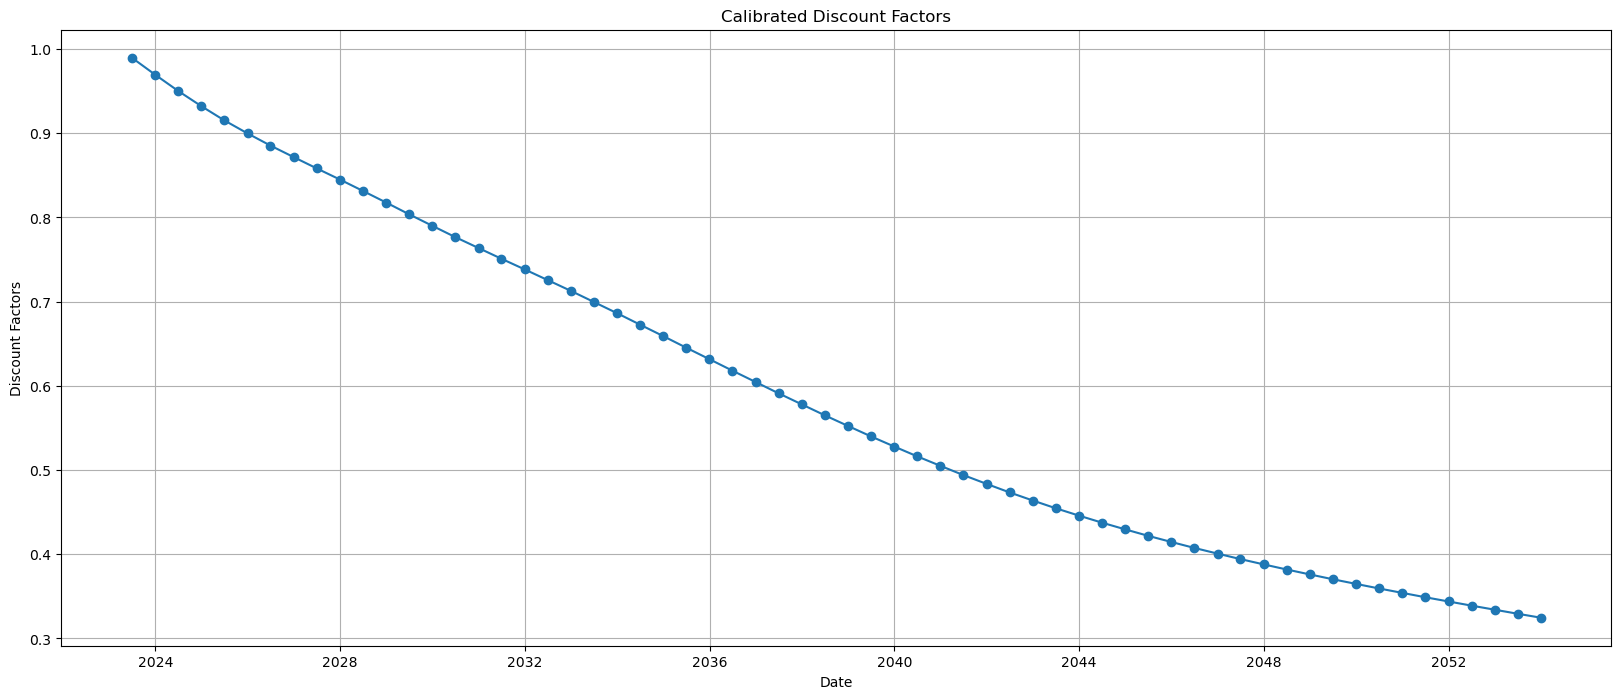

In [20]:
plot_discount_factor(yield_curve)

# Problem 3: Pricing and risk metrics for US Treasury bonds

## a. US Treasury pricing on the calibrated discount factor curve

Follow Section 5. "Present Value Calculation (no credit risk)" in the QuantLib introductory notebook to re-price the US on-the-run treasuries using the calibrated discount factor curve. 

You will need to switch the bond_engine to use the new on-the-run treasury yield curve:
bond_engine = ql.DiscountingBondEngine(treasury_yield_curve_mid_handle)

Extend the dataframe with the following computed columns for clean mid prices:


| calc_mid |
|---------------|


To validate the calibration, compare the calculated clean mid prices to the original market mid prices.

In [21]:
def compute_calc_mid(df_treasury_symbology, yield_curve):

    treasury_yield_curve_mid_handle = ql.YieldTermStructureHandle(yield_curve)
    bond_engine = ql.DiscountingBondEngine(treasury_yield_curve_mid_handle)

    df_treasury_symbology['calc_mid'] = 0.0

    for index, row in df_treasury_symbology.iterrows():

        bond_object = create_bond_from_symbology(row)
        bond_object.setPricingEngine(bond_engine)
        df_treasury_symbology['calc_mid'][index] = bond_object.cleanPrice()

    return df_treasury_symbology

In [22]:
df_treasury_symbology = compute_calc_mid(df_treasury_symbology, yield_curve)
df_treasury_symbology[['mid','calc_mid']]

,mid,calc_mid
0,97.9922,97.9922
1,100.3359,100.3359
2,99.8672,99.8672
3,100.4063,100.4063
4,100.0781,100.0781
5,99.5762,99.5762
6,99.7656,99.7656


## b. Compute analytical DV01, Duration and Convexity for US on-the-run treasuries (using flat yield)

Compute analytical DV01, Duration and Convexity metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Remember that DV01 = Dirty_Price * Duration. 

Extend the dataframe with the following calculated risk metrics:


| dv01 | duration | convexity |
|-------|-------|-------------|


In [23]:
def compute_analytical_metrics(df_treasury_symbology, calc_date):

    flat_rate = ql.SimpleQuote(0.05)
    rate_handle = ql.QuoteHandle(flat_rate)
    day_count = ql.Actual360()
    compounding = ql.Compounded
    coupon_freq = ql.Semiannual
    continuous_comp = ql.Continuous

    flat_int_rate = ql.InterestRate(flat_rate.value(), day_count, compounding, coupon_freq)
    flat_yield_curve = ql.FlatForward(calc_date, rate_handle, day_count, continuous_comp)
    flat_yield_curve_handle = ql.YieldTermStructureHandle(flat_yield_curve)

    # treasury_yield_curve_mid_handle = ql.YieldTermStructureHandle(yield_curve)
    # bond_engine = ql.DiscountingBondEngine(treasury_yield_curve_mid_handle)

    bond_engine = ql.DiscountingBondEngine(flat_yield_curve_handle)
    # fixed_rate_bond.setPricingEngine(bond_engine)

    df_treasury_symbology['dv01'] = 0.0
    df_treasury_symbology['duration'] = 0.0
    df_treasury_symbology['convexity'] = 0.0

    for index, row in df_treasury_symbology.iterrows():
        
        bond_object = create_bond_from_symbology(row)
        bond_object.setPricingEngine(bond_engine)
        bond_duration = ql.BondFunctions.duration(bond_object, flat_int_rate)
        bond_convexity = ql.BondFunctions.convexity(bond_object, flat_int_rate)
        bond_dirty_price = bond_object.dirtyPrice()

        df_treasury_symbology['dv01'][index] = bond_dirty_price*bond_duration
        df_treasury_symbology['duration'][index] = bond_duration
        df_treasury_symbology['convexity'][index] = bond_convexity
        
    return df_treasury_symbology

In [24]:
df_treasury_symbology = compute_analytical_metrics(df_treasury_symbology, calc_date)
df_treasury_symbology[['dv01','duration','convexity']]

,dv01,duration,convexity
0,1284.351516,16.542141,396.278033
1,1124.548137,13.221604,230.117731
2,717.664718,8.149946,78.483364
3,557.113098,6.094634,43.103963
4,422.329322,4.511348,23.655690
5,183.819151,1.878534,4.507620
6,272.135546,2.828572,9.611725


## c. Compute scenario DV01, Duration and Convexity for US on-the-run treasuries (using calibrated yield curve)

Compute the scenario DV01, Duration and Convexity metrics using +/-1bp interest rate shocks, as described in Section 6. "Market Data Scenarios" in the QuantLib introductory notebook.

Remember that DV01 = Dirty_Price * Duration.

Extend the dataframe with the following scenario sensitivities metrics:

| scen_dv01 | scen_duration | scen_convexity |
|-------|-------|-------------|



In [25]:
def compute_scenario_metrics(df_treasury_symbology, yield_curve):

    day_count = ql.Actual360()
    compounding = ql.Compounded
    coupon_freq = ql.Semiannual

    yield_curve_handle = ql.YieldTermStructureHandle(yield_curve)

    interest_rate_bump = ql.SimpleQuote(0.0)
    yield_curve_bumped = ql.ZeroSpreadedTermStructure(yield_curve_handle, ql.QuoteHandle(interest_rate_bump))

    bond_engine = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(yield_curve_bumped))

    df_treasury_symbology['scen_dv01'] = 0.0
    df_treasury_symbology['scen_duration'] = 0.0
    df_treasury_symbology['scen_convexity'] = 0.0

    for index, row in df_treasury_symbology.iterrows():
        
        bond_object = create_bond_from_symbology(row)
        bond_object.setPricingEngine(bond_engine)

        interest_rate_bump.setValue(0.0001)

        int_rate = ql.InterestRate(interest_rate_bump.value(), day_count, compounding, coupon_freq)
        bond_duration = ql.BondFunctions.duration(bond_object, int_rate)
        bond_convexity = ql.BondFunctions.convexity(bond_object, int_rate)

        bond_dirty_price = bond_object.dirtyPrice()

        df_treasury_symbology['scen_dv01'][index] = bond_dirty_price*bond_duration
        df_treasury_symbology['scen_duration'][index] = bond_duration
        df_treasury_symbology['scen_convexity'][index] = bond_convexity

    return df_treasury_symbology

In [26]:
df_treasury_symbology = compute_scenario_metrics(df_treasury_symbology, yield_curve)
df_treasury_symbology[['scen_dv01','scen_duration','scen_convexity']]

,scen_dv01,scen_duration,scen_convexity
0,2210.694460,22.460976,611.920259
1,1593.184583,15.797720,296.541706
2,875.902485,8.726467,87.201533
3,642.050168,6.387803,46.599013
4,468.645663,4.677091,25.216684
5,192.346284,1.928537,4.745232
6,290.352876,2.910584,10.148568


# Problem 4: Pricing and risk metrics for corporate bonds

## a. Create the on-the-run corporate bond objects

Restrict the symbology dataframe to fixed rate corporate bonds only and create the corporate bond objects.

In [27]:
def filter_bond(df_corp_symbology_):

    df_corp_symbology = df_corp_symbology_.loc[df_corp_symbology_['mty_typ'] == 'AT MATURITY']
    df_corp_symbology = df_corp_symbology.loc[df_corp_symbology['rank'] == 'Sr Unsecured']
    df_corp_symbology = df_corp_symbology.loc[df_corp_symbology['cpn_type'] == 'FIXED']
    df_corp_symbology = df_corp_symbology.reset_index(drop=True)

    df_corp_symbology = df_corp_symbology[['ticker','figi','security','name','dcc','days_settle','coupon','start_date','acc_first','maturity','cpn_freq']]
    df_corp_symbology = calculate_ttm(df_corp_symbology)

    return df_corp_symbology


def join_corporate_with_market(df_corp_symbology, df_market):

    df_corporate = pd.merge(df_corp_symbology, df_market,  how='left', left_on=['ticker','figi'], right_on = ['ticker','figi']).dropna()
    # df_corporate = df_corporate[['date','ticker','bid','ask','mid_clean','bid_yield','ask_yield','mid_yield','term','TTM']]
    df_corporate = df_corporate.rename(columns={'mid_clean': 'mid'})

    df_corporate = df_corporate.reset_index(drop=True)

    df_corporate = df_corporate.drop(columns=['mid_dirty'])

    return df_corporate

In [28]:
df_corp_symbology_ = pd.read_excel('data/corp_symbology.xlsx', sheet_name='Sheet1')
# print(df_corp_symbology_.columns)

df_corp_symbology = filter_bond(df_corp_symbology_)
df_corp_symbology = join_corporate_with_market(df_corp_symbology, df_market)
df_corp_symbology

,ticker,figi,security,name,dcc,days_settle,coupon,start_date,acc_first,maturity,...,TTM,date,class,isin,bid,ask,mid,bid_yield,ask_yield,mid_yield
0,DIS,BBG00QNKP8R8,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,30/360,2,6.550,2019-11-22,2019-09-15,2033-03-15,...,10.063889,2023-04-14,Corp,US254687DV52,115.163,115.984,115.574,4.624,4.529,4.5765
1,DIS,BBG00QNKR4J4,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,30/360,2,6.200,2019-11-22,2019-06-15,2034-12-15,...,11.841667,2023-04-14,Corp,US254687DZ66,112.939,113.586,113.262,4.742,4.674,4.7080
2,DIS,BBG00QNKRV04,DIS 6.4 12/15/35,WALT DISNEY COMPANY/THE,30/360,2,6.400,2019-11-22,2019-06-15,2035-12-15,...,12.855556,2023-04-14,Corp,US254687EB89,114.645,115.438,115.042,4.838,4.761,4.7995
3,DIS,BBG00QNKSCY8,DIS 6.15 03/01/37,WALT DISNEY COMPANY/THE,30/360,2,6.150,2019-11-22,2019-09-01,2037-03-01,...,14.083333,2023-04-14,Corp,US254687EF93,111.153,112.380,111.767,5.023,4.908,4.9655
4,DIS,BBG00QNKSBB5,DIS 6.65 11/15/37,WALT DISNEY COMPANY/THE,30/360,2,6.650,2019-11-22,2019-11-15,2037-11-15,...,14.802778,2023-04-14,Corp,US254687EH59,118.135,119.168,118.652,4.895,4.805,4.8500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,VZ,BBG00HC11V79,VZ 4 1/2 08/10/33,VERIZON COMMUNICATIONS,30/360,2,4.500,2017-08-10,2017-08-10,2033-08-10,...,10.475000,2023-04-14,Corp,US92343VEA89,96.081,96.791,96.436,4.990,4.899,4.9445
84,VZ,BBG00JKZK9K4,VZ 3.376 02/15/25,VERIZON COMMUNICATIONS,30/360,2,3.376,2018-01-19,2017-08-16,2025-02-15,...,1.869444,2023-04-14,Corp,US92343VEN01,97.932,98.164,98.048,4.567,4.432,4.4995
85,VZ,BBG00M1BQWX0,VZ 4.329 09/21/28,VERIZON COMMUNICATIONS,30/360,2,4.329,2018-10-22,2018-06-21,2028-09-21,...,5.519444,2023-04-14,Corp,US92343VER15,98.655,99.025,98.840,4.611,4.533,4.5720
86,VZ,BBG00ZLKTDJ4,VZ 0 3/4 03/22/24,VERIZON COMMUNICATIONS,30/360,2,0.750,2021-03-22,2021-03-22,2024-03-22,...,0.952778,2023-04-14,Corp,US92343VGF58,95.975,96.327,96.151,5.251,4.846,5.0485


In [29]:
details_ = df_corp_symbology.iloc[0].to_dict()
fixed_rate_bond_ = create_bond_from_symbology(details_)

## b. Compute analytical Yields and Z-Spreads

Compute analytical Yields and Z-Spreads metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_yield | calc_zspread |
|-------|-------------|


In [30]:
def compute_analytical_corp(df_corp_symbology):

    # Analytical yields assume that the yield curve is flat, which means that the yield is the same for all maturities.

    df_corp_symbology['calc_yield'] = 0.0
    df_corp_symbology['calc_zspread'] = 0.0

    flat_rate = ql.SimpleQuote(0.05)
    rate_handle = ql.QuoteHandle(flat_rate)
    day_count = ql.Actual360()
    compounding = ql.Compounded
    coupon_freq = ql.Semiannual
    continuous_comp = ql.Continuous

    flat_int_rate = ql.InterestRate(flat_rate.value(), day_count, compounding, coupon_freq)
    flat_yield_curve = ql.FlatForward(calc_date, rate_handle, day_count, continuous_comp)
    flat_yield_curve_handle = ql.YieldTermStructureHandle(flat_yield_curve)

    bond_engine = ql.DiscountingBondEngine(flat_yield_curve_handle)

    for index, row in df_corp_symbology.iterrows():
            
        bond_object = create_bond_from_symbology(row)
        bond_object.setPricingEngine(bond_engine)
        bond_duration = ql.BondFunctions.duration(bond_object, flat_int_rate)
        bond_convexity = ql.BondFunctions.convexity(bond_object, flat_int_rate)
        # print(bond_object.cleanPrice())
        # print(bond_object.dayCounter())

        settle_date = bond_object.settlementDate(calc_date)
        day_count = bond_object.dayCounter()
        
        bond_analytical_yield = bond_object.bondYield(row['mid'], day_count, compounding, coupon_freq,settle_date)*100
        # bond_analytical_yield = ql.BondFunctions.bondYield(bond_object, row['mid'], day_count, compounding, coupon_freq,settle_date)*100

        df_corp_symbology['calc_yield'][index] = bond_analytical_yield
        # print(bond_analytical_yield)

        bond_zspread = ql.BondFunctions.zSpread(bond_object, row['mid'], flat_yield_curve, day_count, compounding, coupon_freq, settle_date)
        # print(bond_zspread)
        df_corp_symbology['calc_zspread'][index] = bond_zspread

    return df_corp_symbology

In [31]:
df_corp_symbology = compute_analytical_corp(df_corp_symbology)
df_corp_symbology[['calc_yield','calc_zspread']]

,calc_yield,calc_zspread
0,4.576648,-0.005533
1,4.707955,-0.004247
2,4.799722,-0.003340
3,4.965364,-0.001706
4,4.849811,-0.002851
...,...,...
83,4.944573,-0.001921
84,4.499626,-0.006450
85,4.572207,-0.005606
86,5.048017,-0.000904


## c. Validate Z-Spread computation for a few fixed rate corporate bonds

Pick 3 corporate bonds (at your discretion) and use function below to re-price them using the calibrated flat z-spread. Follow the example in Section 9. "Duration, Convexity and Z-Spread (flat yield model)".

Validate that you match the original market price, which were used as input to the z-Spread function.


In [32]:
def calc_clean_price_with_zspread(fixed_rate_bond, yield_curve_handle, zspread):
    zspread_quote = ql.SimpleQuote(zspread)
    zspread_quote_handle = ql.QuoteHandle(zspread_quote)
    yield_curve_bumped = ql.ZeroSpreadedTermStructure(yield_curve_handle, zspread_quote_handle, ql.Compounded, ql.Semiannual)
    yield_curve_bumped_handle = ql.YieldTermStructureHandle(yield_curve_bumped)
    
    # Set Valuation engine
    bond_engine = ql.DiscountingBondEngine(yield_curve_bumped_handle)
    fixed_rate_bond.setPricingEngine(bond_engine)
    bond_clean_price = fixed_rate_bond.cleanPrice()
    return bond_clean_price


In [33]:
flat_rate = ql.SimpleQuote(0.05)
rate_handle = ql.QuoteHandle(flat_rate)
day_count = ql.Actual360()
compounding = ql.Compounded
coupon_freq = ql.Semiannual
continuous_comp = ql.Continuous

flat_int_rate = ql.InterestRate(flat_rate.value(), day_count, compounding, coupon_freq)
flat_yield_curve = ql.FlatForward(calc_date, rate_handle, day_count, continuous_comp)
flat_yield_curve_handle = ql.YieldTermStructureHandle(flat_yield_curve)

In [34]:
# corporate bond 1

details1 = df_corp_symbology.iloc[86].to_dict()
corp_bond1 = create_bond_from_symbology(details1)
market_price1 = details1['mid']
zspread1 = details1['calc_zspread']
zspread_price1 = calc_clean_price_with_zspread(corp_bond1, flat_yield_curve_handle, zspread1)

print('Bond Z-Spread bps =', round(zspread1 * 10000, 2))
print('Bond Market Price =', market_price1)
print('Bond Z-Spread Price =', zspread_price1)
print('Bond Price Diff =', zspread_price1 - market_price1)

Bond Z-Spread bps = -9.04
Bond Market Price = 96.151
Bond Z-Spread Price = 96.15100000046273
Bond Price Diff = 4.6273385123640765e-10


In [35]:
# corporate bond 2

details2 = df_corp_symbology.iloc[35].to_dict()
corp_bond2 = create_bond_from_symbology(details2)
market_price2 = details2['mid']
zspread2 = details2['calc_zspread']
zspread_price2 = calc_clean_price_with_zspread(corp_bond2, flat_yield_curve_handle, zspread2)

print('Bond Z-Spread bps =', round(zspread2 * 10000, 2))
print('Bond Market Price =', market_price2)
print('Bond Z-Spread Price =', zspread_price2)
print('Bond Price Diff =', zspread_price2 - market_price2)

Bond Z-Spread bps = 8.14
Bond Market Price = 85.314
Bond Z-Spread Price = 85.31400000045812
Bond Price Diff = 4.581295343086822e-10


In [36]:
# corporate bond 3

details3 = df_corp_symbology.iloc[55].to_dict()
corp_bond3 = create_bond_from_symbology(details3)
market_price3 = details3['mid']
zspread3 = details3['calc_zspread']
zspread_price3 = calc_clean_price_with_zspread(corp_bond3, flat_yield_curve_handle, zspread3)

print('Bond Z-Spread bps =', round(zspread3 * 10000, 2))
print('Bond Market Price =', market_price3)
print('Bond Z-Spread Price =', zspread_price3)
print('Bond Price Diff =', zspread_price3 - market_price3)

Bond Z-Spread bps = 6.07
Bond Market Price = 88.34
Bond Z-Spread Price = 88.34000000027234
Bond Price Diff = 2.723368197621312e-10


## d. Compute Duration and Convexity for fixed rate corporate bonds (using flat yield)

Compute analytical Duration and Convexity metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_duration | calc_convexity |
|-------|-------------|


In [37]:
df_corp_symbology = compute_analytical_metrics(df_corp_symbology, calc_date)
df_corp_symbology = df_corp_symbology.rename({'duration': 'calc_duration', 'convexity': 'calc_convexity'}, axis=1)
df_corp_symbology[['calc_duration','calc_convexity']]

,calc_duration,calc_convexity
0,7.475021,69.672805
1,8.389227,90.123587
2,8.839865,101.459982
3,9.598593,119.268801
4,9.612866,123.519228
...,...,...
83,8.154305,80.714288
84,1.763137,4.024363
85,4.819795,27.235757
86,0.916817,1.288706
